In [9]:
#bert-large-uncased

In [10]:
import json
import numpy as np
import nltk
import time
import random
import string
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, TFBertForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [11]:
# Load and preprocess your dataset
with open('Combined_training.json', 'r') as f:
    data = json.load(f)

# Extract patterns and responses
questions = []
labels = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        questions.append(pattern)
        labels.append(intent['tag'])

In [12]:
# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Load BERT tokenizer
MODEL_TYPE = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)

In [13]:
# Tokenize the data
def tokenize_data(questions, max_length):
    encodings = tokenizer(questions, truncation=True, padding=True, max_length=max_length)
    return encodings

# Convert data to TensorFlow Dataset format
def convert_to_tf_dataset(encodings, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    dataset = dataset.shuffle(len(labels)).batch(batch_size)
    return dataset

In [14]:
# Hyperparameters
MAX_LENGTH = 128
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
EPOCHS = 10
N_SPLITS = 5

In [15]:
# K-fold cross-validation
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold = 0
results = []

training_times = []
training_losses = []
validation_losses = []

for train_index, test_index in kf.split(questions):
    fold += 1
    print(f"Fold {fold}")

    train_questions = [questions[i] for i in train_index]
    test_questions = [questions[i] for i in test_index]
    train_labels = [encoded_labels[i] for i in train_index]
    test_labels = [encoded_labels[i] for i in test_index]

    train_encodings = tokenize_data(train_questions, max_length=MAX_LENGTH)
    test_encodings = tokenize_data(test_questions, max_length=MAX_LENGTH)

    train_dataset = convert_to_tf_dataset(train_encodings, train_labels, batch_size=BATCH_SIZE)
    test_dataset = convert_to_tf_dataset(test_encodings, test_labels, batch_size=BATCH_SIZE)

    # Load BERT model for sequence classification
    model = TFBertForSequenceClassification.from_pretrained(MODEL_TYPE, num_labels=len(label_encoder.classes_))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Train the model
    start_time = time.time()
    history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, verbose=1)
    training_time = time.time() - start_time

    training_times.append(training_time)
    training_losses.append(np.mean(history.history['loss']))
    validation_losses.append(np.mean(history.history['val_loss']))

    # Evaluate the model
    predictions = model.predict(test_dataset).logits
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(test_labels, predictions) * 100
    precision = precision_score(test_labels, predictions, average='weighted') * 100
    recall = recall_score(test_labels, predictions, average='weighted') * 100
    f1 = f1_score(test_labels, predictions, average='weighted') * 100

    results.append({
        'fold': fold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

    print(f"Fold {fold} results - Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1 Score: {f1:.2f}%")

Fold 1


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
3/3 [==============================] - 21s 4s/step - loss: 2.8744 - accuracy: 0.0714 - val_loss: 2.8005 - val_accuracy: 0.1429
Epoch 2/10
3/3 [==============================] - 8s 3s/step - loss: 2.7952 - accuracy: 0.1071 - val_loss: 2.5837 - val_accuracy: 0.3333
Epoch 3/10
3/3 [==============================] - 8s 3s/step - loss: 2.5263 - accuracy: 0.2500 - val_loss: 2.2374 - val_accuracy: 0.4286
Epoch 4/10
3/3 [==============================] - 8s 3s/step - loss: 2.2314 - accuracy: 0.4048 - val_loss: 2.0012 - val_accuracy: 0.5714
Epoch 5/10
3/3 [==============================] - 9s 3s/step - loss: 2.0431 - accuracy: 0.5714 - val_loss: 1.7917 - val_accuracy: 0.6667
Epoch 6/10
3/3 [==============================] - 9s 3s/step - loss: 1.8620 - accuracy: 0.7381 - val_loss: 1.5416 - val_accuracy: 0.9048
Epoch 7/10
3/3 [==============================] - 9s 3s/step - loss: 1.6122 - accuracy: 0.8214 - val_loss: 1.4327 - val_accuracy: 0.8571
Epoch 8/10
3/3 [========================

1/1 [==============================] - 3s 3s/step
Fold 1 results - Accuracy: 9.52%, Precision: 7.62%, Recall: 9.52%, F1 Score: 8.47%
Fold 2


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
3/3 [==============================] - 20s 4s/step - loss: 2.9203 - accuracy: 0.0357 - val_loss: 2.7853 - val_accuracy: 0.0476
Epoch 2/10
3/3 [==============================] - 9s 3s/step - loss: 2.7340 - accuracy: 0.1310 - val_loss: 2.8012 - val_accuracy: 0.1905
Epoch 3/10
3/3 [==============================] - 10s 3s/step - loss: 2.5687 - accuracy: 0.1786 - val_loss: 2.7835 - val_accuracy: 0.0476
Epoch 4/10
3/3 [==============================] - 9s 3s/step - loss: 2.4223 - accuracy: 0.2738 - val_loss: 2.5673 - val_accuracy: 0.2381
Epoch 5/10
3/3 [==============================] - 10s 3s/step - loss: 2.2875 - accuracy: 0.4048 - val_loss: 2.5224 - val_accuracy: 0.2381
Epoch 6/10
3/3 [==============================] - 9s 3s/step - loss: 2.0540 - accuracy: 0.5119 - val_loss: 2.1851 - val_accuracy: 0.3810
Epoch 7/10
3/3 [==============================] - 9s 3s/step - loss: 1.7414 - accuracy: 0.6071 - val_loss: 1.9166 - val_accuracy: 0.6190
Epoch 8/10
3/3 [======================

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
3/3 [==============================] - 19s 4s/step - loss: 2.8250 - accuracy: 0.0595 - val_loss: 2.7676 - val_accuracy: 0.0476
Epoch 2/10
3/3 [==============================] - 9s 3s/step - loss: 2.6653 - accuracy: 0.1548 - val_loss: 2.6157 - val_accuracy: 0.1905
Epoch 3/10
3/3 [==============================] - 9s 3s/step - loss: 2.5628 - accuracy: 0.2381 - val_loss: 2.3262 - val_accuracy: 0.3333
Epoch 4/10
3/3 [==============================] - 9s 3s/step - loss: 2.3181 - accuracy: 0.2738 - val_loss: 2.1059 - val_accuracy: 0.2857
Epoch 5/10
3/3 [==============================] - 9s 3s/step - loss: 2.1276 - accuracy: 0.3690 - val_loss: 1.8644 - val_accuracy: 0.2857
Epoch 6/10
3/3 [==============================] - 9s 3s/step - loss: 2.0002 - accuracy: 0.3810 - val_loss: 1.6550 - val_accuracy: 0.5238
Epoch 7/10
3/3 [==============================] - 9s 3s/step - loss: 1.7334 - accuracy: 0.6310 - val_loss: 1.5124 - val_accuracy: 0.6667
Epoch 8/10
3/3 [========================

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
3/3 [==============================] - 18s 3s/step - loss: 2.8293 - accuracy: 0.0714 - val_loss: 2.7956 - val_accuracy: 0.0952
Epoch 2/10
3/3 [==============================] - 9s 3s/step - loss: 2.4903 - accuracy: 0.2976 - val_loss: 2.7473 - val_accuracy: 0.0952
Epoch 3/10
3/3 [==============================] - 9s 3s/step - loss: 2.2411 - accuracy: 0.3571 - val_loss: 2.7443 - val_accuracy: 0.0952
Epoch 4/10
3/3 [==============================] - 9s 3s/step - loss: 2.0798 - accuracy: 0.4048 - val_loss: 2.6481 - val_accuracy: 0.1905
Epoch 5/10
3/3 [==============================] - 9s 3s/step - loss: 1.9286 - accuracy: 0.4643 - val_loss: 2.4441 - val_accuracy: 0.2857
Epoch 6/10
3/3 [==============================] - 9s 3s/step - loss: 1.8531 - accuracy: 0.4762 - val_loss: 2.3256 - val_accuracy: 0.3810
Epoch 7/10
3/3 [==============================] - 9s 3s/step - loss: 1.6286 - accuracy: 0.6667 - val_loss: 2.1383 - val_accuracy: 0.4286
Epoch 8/10
3/3 [========================

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
3/3 [==============================] - 19s 4s/step - loss: 2.8265 - accuracy: 0.0833 - val_loss: 2.7400 - val_accuracy: 0.0476
Epoch 2/10
3/3 [==============================] - 9s 3s/step - loss: 2.5810 - accuracy: 0.1310 - val_loss: 2.5102 - val_accuracy: 0.1905
Epoch 3/10
3/3 [==============================] - 9s 3s/step - loss: 2.4123 - accuracy: 0.3095 - val_loss: 2.2498 - val_accuracy: 0.3333
Epoch 4/10
3/3 [==============================] - 9s 3s/step - loss: 2.1981 - accuracy: 0.4405 - val_loss: 2.1210 - val_accuracy: 0.6190
Epoch 5/10
3/3 [==============================] - 9s 3s/step - loss: 2.0297 - accuracy: 0.6071 - val_loss: 1.8773 - val_accuracy: 0.7619
Epoch 6/10
3/3 [==============================] - 9s 3s/step - loss: 1.8130 - accuracy: 0.7619 - val_loss: 1.6719 - val_accuracy: 0.8571
Epoch 7/10
3/3 [==============================] - 9s 3s/step - loss: 1.5412 - accuracy: 0.7976 - val_loss: 1.4072 - val_accuracy: 0.9524
Epoch 8/10
3/3 [========================

In [16]:
# Calculate and print average metrics
average_results = {metric: np.mean([result[metric] for result in results]) for metric in results[0].keys() if metric != 'fold'}
average_training_time = np.mean(training_times)
average_training_loss = np.mean(training_losses)
average_validation_loss = np.mean(validation_losses)

print("\nAverage results across all folds:")
for metric, value in average_results.items():
    print(f"{metric.capitalize()}: {value:.2f}%")

print(f"Average Training Time: {average_training_time:.2f} seconds")
print(f"Average Training Loss: {average_training_loss:.4f}")
print(f"Average Validation Loss: {average_validation_loss:.4f}")


Average results across all folds:
Accuracy: 7.62%
Precision: 5.95%
Recall: 7.62%
F1: 6.38%
Average Training Time: 100.02 seconds
Average Training Loss: 1.9585
Average Validation Loss: 1.9526


In [17]:
# Save the final model, tokenizer, and label encoder
model.save_pretrained('bert_chatbot_model')
tokenizer.save_pretrained('bert_chatbot_tokenizer')
np.save('label_encoder_classes.npy', label_encoder.classes_)

# Load the model, tokenizer, and label encoder
model = TFBertForSequenceClassification.from_pretrained('bert_chatbot_model')
tokenizer = BertTokenizer.from_pretrained('bert_chatbot_tokenizer')
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('label_encoder_classes.npy', allow_pickle=True)

Some layers from the model checkpoint at bert_chatbot_model were not used when initializing TFBertForSequenceClassification: ['dropout_739']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bert_chatbot_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [18]:
# Load the dataset again for responses
with open('Combined_training.json', 'r') as f:
    data = json.load(f)

# Create a dictionary to map tags to responses
tag_to_response = {intent['tag']: intent['responses'] for intent in data['intents']}

# Function to chat with the model
def chat_with_bert(user_input):
    # Tokenize the user input
    inputs = tokenizer(user_input, return_tensors='tf', max_length=128, padding='max_length', truncation=True)
    
    # Predict the response
    outputs = model(inputs)
    predicted_label = tf.argmax(outputs.logits, axis=1).numpy()[0]
    predicted_tag = label_encoder.inverse_transform([predicted_label])[0]
    
    # Get the response from the tag_to_response dictionary
    if predicted_tag in tag_to_response:
        predicted_response = np.random.choice(tag_to_response[predicted_tag])
    else:
        predicted_response = "I'm not sure how to respond to that. Can you please rephrase?"

    return predicted_response

# Interactive chat
print("Start chatting with the bot (type 'exit' to stop)!")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        print("Chatbot: Goodbye!")
        break
    response = chat_with_bert(user_input)
    print(f"Chatbot: {response}")


Start chatting with the bot (type 'exit' to stop)!


You:  quit


Chatbot: Good day! What do you need help with?


You:  exit


Chatbot: Goodbye!


In [19]:
#distilbert-base-uncased

In [20]:
import json
import numpy as np
import nltk
import time
import random
import string
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [21]:
# Load and preprocess your dataset
with open('Combined_training.json', 'r') as f:
    data = json.load(f)

# Extract patterns and responses
questions = []
labels = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        questions.append(pattern)
        labels.append(intent['tag'])     

In [22]:
# Load DistilBERT tokenizer and model
MODEL_TYPE = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_TYPE)
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_TYPE, num_labels=len(set(labels)))

# Tokenize the data
def tokenize_data(questions, max_length=128):
    return tokenizer(questions, truncation=True, padding=True, max_length=max_length)

# Convert data to TensorFlow Dataset format
def convert_to_tf_dataset(encodings, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    dataset = dataset.shuffle(len(labels)).batch(batch_size)
    return dataset

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [23]:
# Hyperparameters
MAX_LENGTH = 128
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
EPOCHS = 10
N_SPLITS = 5

In [24]:
# K-fold cross-validation
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold = 0
results = []

training_times = []
training_losses = []
validation_losses = []

for train_index, test_index in kf.split(questions):
    fold += 1
    print(f"Fold {fold}")

    train_questions = [questions[i] for i in train_index]
    test_questions = [questions[i] for i in test_index]
    train_labels = [encoded_labels[i] for i in train_index]
    test_labels = [encoded_labels[i] for i in test_index]

    train_encodings = tokenize_data(train_questions, max_length=MAX_LENGTH)
    test_encodings = tokenize_data(test_questions, max_length=MAX_LENGTH)

    train_dataset = convert_to_tf_dataset(train_encodings, train_labels, batch_size=BATCH_SIZE)
    test_dataset = convert_to_tf_dataset(test_encodings, test_labels, batch_size=BATCH_SIZE)

    # Load BERT model for sequence classification
    model = TFBertForSequenceClassification.from_pretrained(MODEL_TYPE, num_labels=len(label_encoder.classes_))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Train the model
    start_time = time.time()
    history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, verbose=1)
    training_time = time.time() - start_time

    training_times.append(training_time)
    training_losses.append(np.mean(history.history['loss']))
    validation_losses.append(np.mean(history.history['val_loss']))

    # Evaluate the model
    predictions = model.predict(test_dataset).logits
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(test_labels, predictions) * 100
    precision = precision_score(test_labels, predictions, average='weighted') * 100
    recall = recall_score(test_labels, predictions, average='weighted') * 100
    f1 = f1_score(test_labels, predictions, average='weighted') * 100

    results.append({
        'fold': fold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

    print(f"Fold {fold} results - Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1 Score: {f1:.2f}%")

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Fold 1


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['distilbert.transformer.layer.4.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.4.output_layer_norm.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.2.attention.out_lin.bias', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.2.ffn.lin2.bias', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.transformer.layer.5.attention.q_lin.weight', 'distilbert.transformer.layer.5.sa_layer_norm.weight', 'distilbert.transformer.layer.2.attention.q_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.bias', 'dis

Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 2.8923 - accuracy: 0.0952 - val_loss: 2.8082 - val_accuracy: 0.1905
Epoch 2/10
3/3 [==============================] - 2s 787ms/step - loss: 2.7251 - accuracy: 0.1190 - val_loss: 2.7026 - val_accuracy: 0.1905
Epoch 3/10
3/3 [==============================] - 2s 790ms/step - loss: 2.5764 - accuracy: 0.2262 - val_loss: 2.4759 - val_accuracy: 0.1905
Epoch 4/10
3/3 [==============================] - 2s 803ms/step - loss: 2.3954 - accuracy: 0.2262 - val_loss: 2.2032 - val_accuracy: 0.1905
Epoch 5/10
3/3 [==============================] - 2s 812ms/step - loss: 2.1309 - accuracy: 0.3095 - val_loss: 2.0410 - val_accuracy: 0.2857
Epoch 6/10
3/3 [==============================] - 2s 817ms/step - loss: 1.8873 - accuracy: 0.6548 - val_loss: 1.8139 - val_accuracy: 0.5238
Epoch 7/10
3/3 [==============================] - 3s 852ms/step - loss: 1.5858 - accuracy: 0.7024 - val_loss: 1.6292 - val_accuracy: 0.4762
Epoch 8/10
3/3 [=======

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Fold 1 results - Accuracy: 4.76%, Precision: 4.76%, Recall: 4.76%, F1 Score: 4.76%
Fold 2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['distilbert.transformer.layer.4.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.4.output_layer_norm.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.2.attention.out_lin.bias', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.2.ffn.lin2.bias', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.transformer.layer.5.attention.q_lin.weight', 'distilbert.transformer.layer.5.sa_layer_norm.weight', 'distilbert.transformer.layer.2.attention.q_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.bias', 'dis

Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 2.9351 - accuracy: 0.1071 - val_loss: 2.9924 - val_accuracy: 0.1429
Epoch 2/10
3/3 [==============================] - 3s 834ms/step - loss: 2.6950 - accuracy: 0.1786 - val_loss: 2.9981 - val_accuracy: 0.1429
Epoch 3/10
3/3 [==============================] - 3s 826ms/step - loss: 2.6310 - accuracy: 0.1667 - val_loss: 2.8368 - val_accuracy: 0.1429
Epoch 4/10
3/3 [==============================] - 3s 830ms/step - loss: 2.5620 - accuracy: 0.1548 - val_loss: 2.6363 - val_accuracy: 0.1429
Epoch 5/10
3/3 [==============================] - 3s 853ms/step - loss: 2.2787 - accuracy: 0.3571 - val_loss: 2.3978 - val_accuracy: 0.2381
Epoch 6/10
3/3 [==============================] - 3s 858ms/step - loss: 2.0377 - accuracy: 0.3571 - val_loss: 2.2459 - val_accuracy: 0.2857
Epoch 7/10
3/3 [==============================] - 3s 886ms/step - loss: 1.7266 - accuracy: 0.6310 - val_loss: 1.9502 - val_accuracy: 0.4286
Epoch 8/10
3/3 [=======

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Fold 2 results - Accuracy: 9.52%, Precision: 9.52%, Recall: 9.52%, F1 Score: 9.52%
Fold 3


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['distilbert.transformer.layer.4.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.4.output_layer_norm.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.2.attention.out_lin.bias', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.2.ffn.lin2.bias', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.transformer.layer.5.attention.q_lin.weight', 'distilbert.transformer.layer.5.sa_layer_norm.weight', 'distilbert.transformer.layer.2.attention.q_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.bias', 'dis

Epoch 1/10
3/3 [==============================] - 8s 1s/step - loss: 2.9109 - accuracy: 0.0595 - val_loss: 2.7885 - val_accuracy: 0.2381
Epoch 2/10
3/3 [==============================] - 3s 844ms/step - loss: 2.6509 - accuracy: 0.1190 - val_loss: 2.6597 - val_accuracy: 0.2381
Epoch 3/10
3/3 [==============================] - 3s 858ms/step - loss: 2.5494 - accuracy: 0.2143 - val_loss: 2.5205 - val_accuracy: 0.2381
Epoch 4/10
3/3 [==============================] - 3s 871ms/step - loss: 2.3065 - accuracy: 0.3214 - val_loss: 2.2262 - val_accuracy: 0.3810
Epoch 5/10
3/3 [==============================] - 3s 866ms/step - loss: 2.0821 - accuracy: 0.4881 - val_loss: 2.1106 - val_accuracy: 0.3810
Epoch 6/10
3/3 [==============================] - 3s 874ms/step - loss: 1.7675 - accuracy: 0.6667 - val_loss: 1.9843 - val_accuracy: 0.2381
Epoch 7/10
3/3 [==============================] - 3s 879ms/step - loss: 1.4888 - accuracy: 0.7143 - val_loss: 1.6436 - val_accuracy: 0.5238
Epoch 8/10
3/3 [=======

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Fold 3 results - Accuracy: 9.52%, Precision: 7.14%, Recall: 9.52%, F1 Score: 7.94%
Fold 4


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['distilbert.transformer.layer.4.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.4.output_layer_norm.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.2.attention.out_lin.bias', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.2.ffn.lin2.bias', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.transformer.layer.5.attention.q_lin.weight', 'distilbert.transformer.layer.5.sa_layer_norm.weight', 'distilbert.transformer.layer.2.attention.q_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.bias', 'dis

Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 2.9468 - accuracy: 0.1071 - val_loss: 3.2259 - val_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 3s 847ms/step - loss: 2.6192 - accuracy: 0.1786 - val_loss: 3.0225 - val_accuracy: 0.0000e+00
Epoch 3/10
3/3 [==============================] - 3s 848ms/step - loss: 2.5808 - accuracy: 0.2500 - val_loss: 2.9803 - val_accuracy: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 3s 848ms/step - loss: 2.3867 - accuracy: 0.2262 - val_loss: 2.8707 - val_accuracy: 0.1429
Epoch 5/10
3/3 [==============================] - 3s 854ms/step - loss: 2.2012 - accuracy: 0.3810 - val_loss: 2.7233 - val_accuracy: 0.1905
Epoch 6/10
3/3 [==============================] - 3s 854ms/step - loss: 1.9510 - accuracy: 0.4881 - val_loss: 2.4648 - val_accuracy: 0.1905
Epoch 7/10
3/3 [==============================] - 3s 954ms/step - loss: 1.7445 - accuracy: 0.6190 - val_loss: 2.3336 - val_accuracy: 0.3333
Epoch 8/10


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Fold 4 results - Accuracy: 0.00%, Precision: 0.00%, Recall: 0.00%, F1 Score: 0.00%
Fold 5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['distilbert.transformer.layer.4.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.4.output_layer_norm.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.2.attention.out_lin.bias', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.2.ffn.lin2.bias', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.transformer.layer.5.attention.q_lin.weight', 'distilbert.transformer.layer.5.sa_layer_norm.weight', 'distilbert.transformer.layer.2.attention.q_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.bias', 'dis

Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 2.9323 - accuracy: 0.1190 - val_loss: 2.8315 - val_accuracy: 0.1429
Epoch 2/10
3/3 [==============================] - 3s 878ms/step - loss: 2.7036 - accuracy: 0.1548 - val_loss: 2.8340 - val_accuracy: 0.1429
Epoch 3/10
3/3 [==============================] - 3s 862ms/step - loss: 2.5790 - accuracy: 0.2381 - val_loss: 2.6738 - val_accuracy: 0.1429
Epoch 4/10
3/3 [==============================] - 3s 860ms/step - loss: 2.4489 - accuracy: 0.2381 - val_loss: 2.3749 - val_accuracy: 0.2381
Epoch 5/10
3/3 [==============================] - 3s 863ms/step - loss: 2.1681 - accuracy: 0.4762 - val_loss: 2.1669 - val_accuracy: 0.3333
Epoch 6/10
3/3 [==============================] - 3s 919ms/step - loss: 1.9348 - accuracy: 0.5000 - val_loss: 1.9447 - val_accuracy: 0.4286
Epoch 7/10
3/3 [==============================] - 3s 878ms/step - loss: 1.6869 - accuracy: 0.6429 - val_loss: 1.7072 - val_accuracy: 0.7143
Epoch 8/10
3/3 [=======

In [25]:
# Calculate and print average metrics
average_results = {metric: np.mean([result[metric] for result in results]) for metric in results[0].keys() if metric != 'fold'}
average_training_time = np.mean(training_times)
average_training_loss = np.mean(training_losses)
average_validation_loss = np.mean(validation_losses)

print("\nAverage results across all folds:")
for metric, value in average_results.items():
    print(f"{metric.capitalize()}: {value:.2f}%")

print(f"Average Training Time: {average_training_time:.2f} seconds")
print(f"Average Training Loss: {average_training_loss:.4f}")
print(f"Average Validation Loss: {average_validation_loss:.4f}")


Average results across all folds:
Accuracy: 5.71%
Precision: 5.24%
Recall: 5.71%
F1: 5.40%
Average Training Time: 30.91 seconds
Average Training Loss: 1.9524
Average Validation Loss: 2.0947


In [26]:
# Save the final model, tokenizer, and label encoder
model.save_pretrained('bert_chatbot_model')
tokenizer.save_pretrained('bert_chatbot_tokenizer')
np.save('label_encoder_classes.npy', label_encoder.classes_)

# Load the model, tokenizer, and label encoder
model = TFBertForSequenceClassification.from_pretrained('bert_chatbot_model')
tokenizer = BertTokenizer.from_pretrained('bert_chatbot_tokenizer')
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('label_encoder_classes.npy', allow_pickle=True)


Some layers from the model checkpoint at bert_chatbot_model were not used when initializing TFBertForSequenceClassification: ['dropout_1023']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bert_chatbot_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
The tokenizer class you load from this checkpoint is not the same type 

In [27]:
# Load the dataset again for responses
with open('Combined_training.json', 'r') as f:
    data = json.load(f)

# Create a dictionary to map tags to responses
tag_to_response = {intent['tag']: intent['responses'] for intent in data['intents']}

# Function to chat with the model
def chat_with_bert(user_input):
    # Tokenize the user input
    inputs = tokenizer(user_input, return_tensors='tf', max_length=128, padding='max_length', truncation=True)
    
    # Predict the response
    outputs = model(inputs)
    predicted_label = tf.argmax(outputs.logits, axis=1).numpy()[0]
    predicted_tag = label_encoder.inverse_transform([predicted_label])[0]
    
    # Get the response from the tag_to_response dictionary
    if predicted_tag in tag_to_response:
        predicted_response = np.random.choice(tag_to_response[predicted_tag])
    else:
        predicted_response = "I'm not sure how to respond to that. Can you please rephrase?"

    return predicted_response

# Interactive chat
print("Start chatting with the bot (type 'exit' to stop)!")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        print("Chatbot: Goodbye!")
        break
    response = chat_with_bert(user_input)
    print(f"Chatbot: {response}")


Start chatting with the bot (type 'exit' to stop)!


You:  exit


Chatbot: Goodbye!


In [28]:
#bert-base-uncased

In [29]:
import json
import numpy as np
import nltk
import time
import random
import string
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, TFBertForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [30]:
# Load and preprocess your dataset
with open('Combined_training.json', 'r') as f:
    data = json.load(f)

# Extract patterns and responses
questions = []
labels = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        questions.append(pattern)
        labels.append(intent['tag'])

In [31]:
# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Load BERT tokenizer
MODEL_TYPE = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)

In [32]:
# Tokenize the data
def tokenize_data(questions, max_length):
    encodings = tokenizer(questions, truncation=True, padding=True, max_length=max_length)
    return encodings

# Convert data to TensorFlow Dataset format
def convert_to_tf_dataset(encodings, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    dataset = dataset.shuffle(len(labels)).batch(batch_size)
    return dataset

In [33]:
# Hyperparameters
MAX_LENGTH = 128
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
EPOCHS = 10
N_SPLITS = 5

In [34]:
# K-fold cross-validation
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold = 0
results = []

training_times = []
training_losses = []
validation_losses = []

for train_index, test_index in kf.split(questions):
    fold += 1
    print(f"Fold {fold}")

    train_questions = [questions[i] for i in train_index]
    test_questions = [questions[i] for i in test_index]
    train_labels = [encoded_labels[i] for i in train_index]
    test_labels = [encoded_labels[i] for i in test_index]

    train_encodings = tokenize_data(train_questions, max_length=MAX_LENGTH)
    test_encodings = tokenize_data(test_questions, max_length=MAX_LENGTH)

    train_dataset = convert_to_tf_dataset(train_encodings, train_labels, batch_size=BATCH_SIZE)
    test_dataset = convert_to_tf_dataset(test_encodings, test_labels, batch_size=BATCH_SIZE)

    # Load BERT model for sequence classification
    model = TFBertForSequenceClassification.from_pretrained(MODEL_TYPE, num_labels=len(label_encoder.classes_))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Train the model
    start_time = time.time()
    history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, verbose=1)
    training_time = time.time() - start_time

    training_times.append(training_time)
    training_losses.append(np.mean(history.history['loss']))
    validation_losses.append(np.mean(history.history['val_loss']))

    # Evaluate the model
    predictions = model.predict(test_dataset).logits
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(test_labels, predictions) * 100
    precision = precision_score(test_labels, predictions, average='weighted') * 100
    recall = recall_score(test_labels, predictions, average='weighted') * 100
    f1 = f1_score(test_labels, predictions, average='weighted') * 100

    results.append({
        'fold': fold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

    print(f"Fold {fold} results - Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1 Score: {f1:.2f}%")

Fold 1


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 2.7948 - accuracy: 0.0595 - val_loss: 2.6217 - val_accuracy: 0.1905
Epoch 2/10
3/3 [==============================] - 2s 793ms/step - loss: 2.6356 - accuracy: 0.1310 - val_loss: 2.4861 - val_accuracy: 0.2857
Epoch 3/10
3/3 [==============================] - 2s 793ms/step - loss: 2.4779 - accuracy: 0.2262 - val_loss: 2.3382 - val_accuracy: 0.4286
Epoch 4/10
3/3 [==============================] - 2s 808ms/step - loss: 2.3449 - accuracy: 0.3810 - val_loss: 2.2655 - val_accuracy: 0.4286
Epoch 5/10
3/3 [==============================] - 2s 807ms/step - loss: 2.1861 - accuracy: 0.4881 - val_loss: 2.1421 - val_accuracy: 0.4286
Epoch 6/10
3/3 [==============================] - 3s 839ms/step - loss: 1.9866 - accuracy: 0.6071 - val_loss: 1.8993 - val_accuracy: 0.6190
Epoch 7/10
3/3 [==============================] - 3s 826ms/step - loss: 1.8484 - accuracy: 0.7381 - val_loss: 1.7358 - val_accuracy: 0.6190
Epoch 8/10
3/3 [=======

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 2.7817 - accuracy: 0.1310 - val_loss: 2.8242 - val_accuracy: 0.1429
Epoch 2/10
3/3 [==============================] - 3s 831ms/step - loss: 2.6177 - accuracy: 0.1548 - val_loss: 2.6144 - val_accuracy: 0.2381
Epoch 3/10
3/3 [==============================] - 3s 835ms/step - loss: 2.4445 - accuracy: 0.3333 - val_loss: 2.3664 - val_accuracy: 0.3810
Epoch 4/10
3/3 [==============================] - 3s 839ms/step - loss: 2.2648 - accuracy: 0.4286 - val_loss: 2.1245 - val_accuracy: 0.5238
Epoch 5/10
3/3 [==============================] - 3s 839ms/step - loss: 2.0868 - accuracy: 0.5952 - val_loss: 1.9445 - val_accuracy: 0.7619
Epoch 6/10
3/3 [==============================] - 3s 855ms/step - loss: 1.8985 - accuracy: 0.6905 - val_loss: 1.7764 - val_accuracy: 0.8095
Epoch 7/10
3/3 [==============================] - 3s 851ms/step - loss: 1.7038 - accuracy: 0.7976 - val_loss: 1.6792 - val_accuracy: 0.9524
Epoch 8/10
3/3 [=======

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 2.7892 - accuracy: 0.0833 - val_loss: 2.7056 - val_accuracy: 0.1905
Epoch 2/10
3/3 [==============================] - 3s 854ms/step - loss: 2.6832 - accuracy: 0.1548 - val_loss: 2.6347 - val_accuracy: 0.2381
Epoch 3/10
3/3 [==============================] - 3s 854ms/step - loss: 2.5564 - accuracy: 0.2262 - val_loss: 2.6294 - val_accuracy: 0.2857
Epoch 4/10
3/3 [==============================] - 3s 863ms/step - loss: 2.4637 - accuracy: 0.2857 - val_loss: 2.5912 - val_accuracy: 0.2381
Epoch 5/10
3/3 [==============================] - 3s 866ms/step - loss: 2.3704 - accuracy: 0.2500 - val_loss: 2.4974 - val_accuracy: 0.2857
Epoch 6/10
3/3 [==============================] - 3s 866ms/step - loss: 2.2866 - accuracy: 0.2738 - val_loss: 2.4440 - val_accuracy: 0.2857
Epoch 7/10
3/3 [==============================] - 3s 863ms/step - loss: 2.1242 - accuracy: 0.4524 - val_loss: 2.3159 - val_accuracy: 0.3333
Epoch 8/10
3/3 [=======

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 2.8254 - accuracy: 0.0357 - val_loss: 2.7613 - val_accuracy: 0.1429
Epoch 2/10
3/3 [==============================] - 3s 835ms/step - loss: 2.6910 - accuracy: 0.0714 - val_loss: 2.6783 - val_accuracy: 0.1429
Epoch 3/10
3/3 [==============================] - 3s 836ms/step - loss: 2.5393 - accuracy: 0.1667 - val_loss: 2.6494 - val_accuracy: 0.2381
Epoch 4/10
3/3 [==============================] - 3s 853ms/step - loss: 2.4280 - accuracy: 0.2024 - val_loss: 2.4853 - val_accuracy: 0.2381
Epoch 5/10
3/3 [==============================] - 3s 843ms/step - loss: 2.2766 - accuracy: 0.4286 - val_loss: 2.4272 - val_accuracy: 0.3810
Epoch 6/10
3/3 [==============================] - 3s 854ms/step - loss: 2.1349 - accuracy: 0.5595 - val_loss: 2.2512 - val_accuracy: 0.3333
Epoch 7/10
3/3 [==============================] - 3s 876ms/step - loss: 1.9913 - accuracy: 0.5238 - val_loss: 2.1596 - val_accuracy: 0.3810
Epoch 8/10
3/3 [=======

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 2.8296 - accuracy: 0.0476 - val_loss: 2.7872 - val_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 3s 854ms/step - loss: 2.6041 - accuracy: 0.1905 - val_loss: 2.5424 - val_accuracy: 0.1905
Epoch 3/10
3/3 [==============================] - 3s 857ms/step - loss: 2.5192 - accuracy: 0.2857 - val_loss: 2.4189 - val_accuracy: 0.2857
Epoch 4/10
3/3 [==============================] - 3s 859ms/step - loss: 2.3045 - accuracy: 0.4762 - val_loss: 2.2794 - val_accuracy: 0.4762
Epoch 5/10
3/3 [==============================] - 3s 866ms/step - loss: 2.1535 - accuracy: 0.6310 - val_loss: 2.1355 - val_accuracy: 0.5714
Epoch 6/10
3/3 [==============================] - 3s 870ms/step - loss: 2.0381 - accuracy: 0.6786 - val_loss: 1.9948 - val_accuracy: 0.6190
Epoch 7/10
3/3 [==============================] - 3s 911ms/step - loss: 1.8483 - accuracy: 0.7500 - val_loss: 1.8013 - val_accuracy: 0.7619
Epoch 8/10
3/3 [===

In [35]:
# Calculate and print average metrics
average_results = {metric: np.mean([result[metric] for result in results]) for metric in results[0].keys() if metric != 'fold'}
average_training_time = np.mean(training_times)
average_training_loss = np.mean(training_losses)
average_validation_loss = np.mean(validation_losses)

print("\nAverage results across all folds:")
for metric, value in average_results.items():
    print(f"{metric.capitalize()}: {value:.2f}%")

print(f"Average Training Time: {average_training_time:.2f} seconds")
print(f"Average Training Loss: {average_training_loss:.4f}")
print(f"Average Validation Loss: {average_validation_loss:.4f}")


Average results across all folds:
Accuracy: 7.62%
Precision: 6.67%
Recall: 7.62%
F1: 6.97%
Average Training Time: 30.55 seconds
Average Training Loss: 2.1267
Average Validation Loss: 2.1347


In [36]:
# Save the final model, tokenizer, and label encoder
model.save_pretrained('bert_chatbot_model')
tokenizer.save_pretrained('bert_chatbot_tokenizer')
np.save('label_encoder_classes.npy', label_encoder.classes_)

# Load the model, tokenizer, and label encoder
model = TFBertForSequenceClassification.from_pretrained('bert_chatbot_model')
tokenizer = BertTokenizer.from_pretrained('bert_chatbot_tokenizer')
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('label_encoder_classes.npy', allow_pickle=True)

Some layers from the model checkpoint at bert_chatbot_model were not used when initializing TFBertForSequenceClassification: ['dropout_1251']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bert_chatbot_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [37]:
# Load the dataset again for responses
with open('Combined_training.json', 'r') as f:
    data = json.load(f)

# Create a dictionary to map tags to responses
tag_to_response = {intent['tag']: intent['responses'] for intent in data['intents']}

# Function to chat with the model
def chat_with_bert(user_input):
    # Tokenize the user input
    inputs = tokenizer(user_input, return_tensors='tf', max_length=128, padding='max_length', truncation=True)
    
    # Predict the response
    outputs = model(inputs)
    predicted_label = tf.argmax(outputs.logits, axis=1).numpy()[0]
    predicted_tag = label_encoder.inverse_transform([predicted_label])[0]
    
    # Get the response from the tag_to_response dictionary
    if predicted_tag in tag_to_response:
        predicted_response = np.random.choice(tag_to_response[predicted_tag])
    else:
        predicted_response = "I'm not sure how to respond to that. Can you please rephrase?"

    return predicted_response

# Interactive chat
print("Start chatting with the bot (type 'exit' to stop)!")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        print("Chatbot: Goodbye!")
        break
    response = chat_with_bert(user_input)
    print(f"Chatbot: {response}")

Start chatting with the bot (type 'exit' to stop)!


You:  exit


Chatbot: Goodbye!


In [38]:
#roberta-base

In [39]:
import json
import numpy as np
import nltk
import time
import random
import string
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [40]:
# Load and preprocess your dataset
with open('Combined_training.json', 'r') as f:
    data = json.load(f)

# Extract patterns and responses
questions = []
labels = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        questions.append(pattern)
        labels.append(intent['tag'])

In [41]:
# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Load BERT tokenizer
MODEL_TYPE = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_TYPE)

# Tokenize the data
def tokenize_data(questions, max_length):
    encodings = tokenizer(questions, truncation=True, padding=True, max_length=max_length)
    return encodings

# Convert data to TensorFlow Dataset format
def convert_to_tf_dataset(encodings, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    dataset = dataset.shuffle(len(labels)).batch(batch_size)
    return dataset

In [42]:
# Hyperparameters
MAX_LENGTH = 128
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
EPOCHS = 10
N_SPLITS = 5

In [43]:
# K-fold cross-validation
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold = 0
results = []

training_times = []
training_losses = []
validation_losses = []

for train_index, test_index in kf.split(questions):
    fold += 1
    print(f"Fold {fold}")

    train_questions = [questions[i] for i in train_index]
    test_questions = [questions[i] for i in test_index]
    train_labels = [encoded_labels[i] for i in train_index]
    test_labels = [encoded_labels[i] for i in test_index]

    train_encodings = tokenize_data(train_questions, max_length=MAX_LENGTH)
    test_encodings = tokenize_data(test_questions, max_length=MAX_LENGTH)

    train_dataset = convert_to_tf_dataset(train_encodings, train_labels, batch_size=BATCH_SIZE)
    test_dataset = convert_to_tf_dataset(test_encodings, test_labels, batch_size=BATCH_SIZE)

    # Load BERT model for sequence classification
    model = TFRobertaForSequenceClassification.from_pretrained(MODEL_TYPE, num_labels=len(label_encoder.classes_))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Train the model
    start_time = time.time()
    history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, verbose=1)
    training_time = time.time() - start_time

    training_times.append(training_time)
    training_losses.append(np.mean(history.history['loss']))
    validation_losses.append(np.mean(history.history['val_loss']))

    # Evaluate the model
    predictions = model.predict(test_dataset).logits
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(test_labels, predictions) * 100
    precision = precision_score(test_labels, predictions, average='weighted') * 100
    recall = recall_score(test_labels, predictions, average='weighted') * 100
    f1 = f1_score(test_labels, predictions, average='weighted') * 100

    results.append({
        'fold': fold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

    print(f"Fold {fold} results - Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1 Score: {f1:.2f}%")

Fold 1


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/10
3/3 [==============================] - 8s 1s/step - loss: 2.7761 - accuracy: 0.0714 - val_loss: 2.7332 - val_accuracy: 0.1905
Epoch 2/10
3/3 [==============================] - 3s 842ms/step - loss: 2.7552 - accuracy: 0.1190 - val_loss: 2.7112 - val_accuracy: 0.1905
Epoch 3/10
3/3 [==============================] - 3s 845ms/step - loss: 2.7073 - accuracy: 0.1310 - val_loss: 2.5921 - val_accuracy: 0.1905
Epoch 4/10
3/3 [==============================] - 3s 858ms/step - loss: 2.5360 - accuracy: 0.2024 - val_loss: 2.3939 - val_accuracy: 0.2381
Epoch 5/10
3/3 [==============================] - 3s 864ms/step - loss: 2.2591 - accuracy: 0.4881 - val_loss: 1.9458 - val_accuracy: 0.7619
Epoch 6/10
3/3 [==============================] - 3s 870ms/step - loss: 1.9084 - accuracy: 0.8214 - val_loss: 1.5914 - val_accuracy: 0.9524
Epoch 7/10
3/3 [==============================] - 3s 889ms/step - loss: 1.5648 - accuracy: 0.9643 - val_loss: 1.2549 - val_accuracy: 1.0000
Epoch 8/10
3/3 [=======

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 2.7700 - accuracy: 0.0476 - val_loss: 2.8016 - val_accuracy: 0.1429
Epoch 2/10
3/3 [==============================] - 3s 899ms/step - loss: 2.7340 - accuracy: 0.1548 - val_loss: 2.7741 - val_accuracy: 0.1429
Epoch 3/10
3/3 [==============================] - 3s 889ms/step - loss: 2.6123 - accuracy: 0.2024 - val_loss: 2.6490 - val_accuracy: 0.1905
Epoch 4/10
3/3 [==============================] - 3s 903ms/step - loss: 2.4051 - accuracy: 0.4286 - val_loss: 2.3584 - val_accuracy: 0.4286
Epoch 5/10
3/3 [==============================] - 3s 898ms/step - loss: 2.0547 - accuracy: 0.7500 - val_loss: 1.9581 - val_accuracy: 0.7143
Epoch 6/10
3/3 [==============================] - 3s 944ms/step - loss: 1.7123 - accuracy: 0.8929 - val_loss: 1.6090 - val_accuracy: 0.8095
Epoch 7/10
3/3 [==============================] - 3s 907ms/step - loss: 1.3743 - accuracy: 0.9524 - val_loss: 1.2725 - val_accuracy: 0.8095
Epoch 8/10
3/3 [=======

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/10
3/3 [==============================] - 8s 1s/step - loss: 2.7790 - accuracy: 0.0357 - val_loss: 2.7375 - val_accuracy: 0.1429
Epoch 2/10
3/3 [==============================] - 3s 895ms/step - loss: 2.7563 - accuracy: 0.1190 - val_loss: 2.7234 - val_accuracy: 0.2381
Epoch 3/10
3/3 [==============================] - 3s 898ms/step - loss: 2.7079 - accuracy: 0.2381 - val_loss: 2.6654 - val_accuracy: 0.2857
Epoch 4/10
3/3 [==============================] - 3s 905ms/step - loss: 2.5965 - accuracy: 0.2976 - val_loss: 2.3778 - val_accuracy: 0.3333
Epoch 5/10
3/3 [==============================] - 3s 941ms/step - loss: 2.2522 - accuracy: 0.6310 - val_loss: 1.9708 - val_accuracy: 0.7619
Epoch 6/10
3/3 [==============================] - 3s 912ms/step - loss: 1.8814 - accuracy: 0.8452 - val_loss: 1.6251 - val_accuracy: 0.8095
Epoch 7/10
3/3 [==============================] - 3s 922ms/step - loss: 1.4985 - accuracy: 0.9762 - val_loss: 1.2895 - val_accuracy: 1.0000
Epoch 8/10
3/3 [=======

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/10
3/3 [==============================] - 8s 1s/step - loss: 2.7658 - accuracy: 0.0952 - val_loss: 2.8045 - val_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 3s 880ms/step - loss: 2.6914 - accuracy: 0.1667 - val_loss: 2.8149 - val_accuracy: 0.0000e+00
Epoch 3/10
3/3 [==============================] - 3s 893ms/step - loss: 2.6507 - accuracy: 0.1786 - val_loss: 2.7942 - val_accuracy: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 3s 922ms/step - loss: 2.4640 - accuracy: 0.1786 - val_loss: 2.6070 - val_accuracy: 0.0952
Epoch 5/10
3/3 [==============================] - 3s 896ms/step - loss: 2.1415 - accuracy: 0.5595 - val_loss: 2.2677 - val_accuracy: 0.7143
Epoch 6/10
3/3 [==============================] - 3s 894ms/step - loss: 1.8082 - accuracy: 0.8095 - val_loss: 1.8446 - val_accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 3s 909ms/step - loss: 1.5046 - accuracy: 0.9167 - val_loss: 1.5513 - val_accuracy: 1.0000
Epoch 8/10


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/10
3/3 [==============================] - 8s 1s/step - loss: 2.7809 - accuracy: 0.0357 - val_loss: 2.7748 - val_accuracy: 0.0476
Epoch 2/10
3/3 [==============================] - 3s 896ms/step - loss: 2.7394 - accuracy: 0.1548 - val_loss: 2.7475 - val_accuracy: 0.1429
Epoch 3/10
3/3 [==============================] - 3s 903ms/step - loss: 2.6485 - accuracy: 0.1905 - val_loss: 2.5503 - val_accuracy: 0.1429
Epoch 4/10
3/3 [==============================] - 3s 909ms/step - loss: 2.3552 - accuracy: 0.3333 - val_loss: 2.3132 - val_accuracy: 0.2381
Epoch 5/10
3/3 [==============================] - 3s 916ms/step - loss: 2.0298 - accuracy: 0.7262 - val_loss: 1.9029 - val_accuracy: 0.8571
Epoch 6/10
3/3 [==============================] - 3s 909ms/step - loss: 1.6628 - accuracy: 0.9762 - val_loss: 1.5310 - val_accuracy: 0.9048
Epoch 7/10
3/3 [==============================] - 3s 921ms/step - loss: 1.3543 - accuracy: 0.9881 - val_loss: 1.2041 - val_accuracy: 1.0000
Epoch 8/10
3/3 [=======

In [44]:
# Calculate and print average metrics
average_results = {metric: np.mean([result[metric] for result in results]) for metric in results[0].keys() if metric != 'fold'}
average_training_time = np.mean(training_times)
average_training_loss = np.mean(training_losses)
average_validation_loss = np.mean(validation_losses)

print("\nAverage results across all folds:")
for metric, value in average_results.items():
    print(f"{metric.capitalize()}: {value:.2f}%")

print(f"Average Training Time: {average_training_time:.2f} seconds")
print(f"Average Training Loss: {average_training_loss:.4f}")
print(f"Average Validation Loss: {average_validation_loss:.4f}")


Average results across all folds:
Accuracy: 14.29%
Precision: 14.29%
Recall: 14.29%
F1: 14.29%
Average Training Time: 32.41 seconds
Average Training Loss: 1.8860
Average Validation Loss: 1.8004


In [45]:
# Save the final model, tokenizer, and label encoder
model.save_pretrained('roberta_chatbot_model')
tokenizer.save_pretrained('roberta_chatbot_tokenizer')
np.save('label_encoder_classes.npy', label_encoder.classes_)

# Load the model, tokenizer, and label encoder
model = TFRobertaForSequenceClassification.from_pretrained('roberta_chatbot_model')
tokenizer = RobertaTokenizer.from_pretrained('roberta_chatbot_tokenizer')
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('label_encoder_classes.npy', allow_pickle=True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at roberta_chatbot_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [46]:
# Load the dataset again for responses
with open('Combined_training.json', 'r') as f:
    data = json.load(f)

# Create a dictionary to map tags to responses
tag_to_response = {intent['tag']: intent['responses'] for intent in data['intents']}

# Function to chat with the model
def chat_with_bert(user_input):
    # Tokenize the user input
    inputs = tokenizer(user_input, return_tensors='tf', max_length=128, padding='max_length', truncation=True)
    
    # Predict the response
    outputs = model(inputs)
    predicted_label = tf.argmax(outputs.logits, axis=1).numpy()[0]
    predicted_tag = label_encoder.inverse_transform([predicted_label])[0]
    
    # Get the response from the tag_to_response dictionary
    if predicted_tag in tag_to_response:
        predicted_response = np.random.choice(tag_to_response[predicted_tag])
    else:
        predicted_response = "I'm not sure how to respond to that. Can you please rephrase?"

    return predicted_response

# Interactive chat
print("Start chatting with the bot (type 'exit' to stop)!")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        print("Chatbot: Goodbye!")
        break
    response = chat_with_bert(user_input)
    print(f"Chatbot: {response}")

Start chatting with the bot (type 'exit' to stop)!


You:  exit


Chatbot: Goodbye!


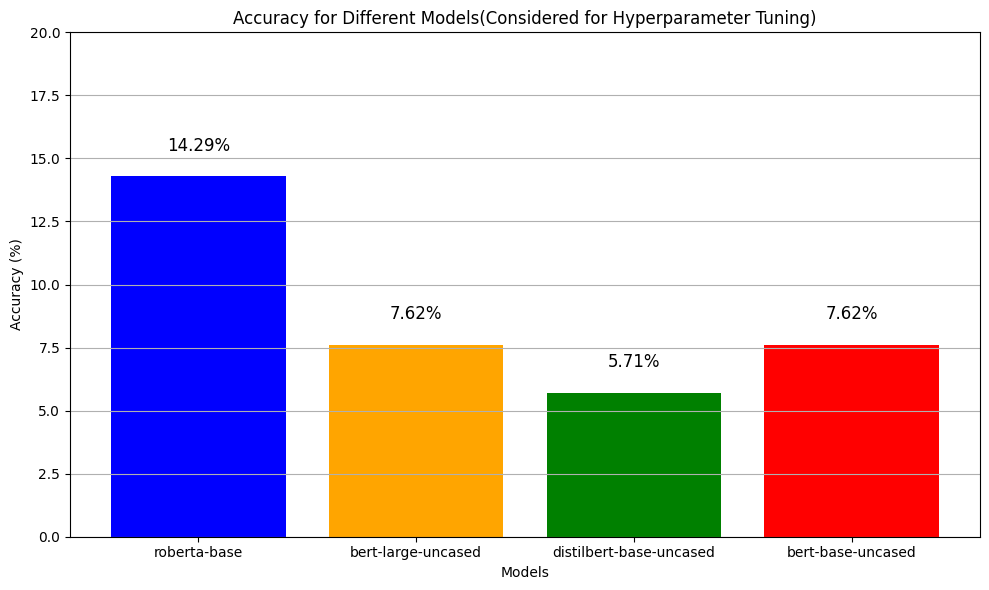

In [49]:
import matplotlib.pyplot as plt

# Data for the plot
models = ['roberta-base', 'bert-large-uncased', 'distilbert-base-uncased', 'bert-base-uncased']
accuracies = [14.29, 7.62, 5.71, 7.62]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 20)  # Set y-axis limit slightly above the highest accuracy for better visualization
plt.title('Accuracy for Different Models(Considered for Hyperparameter Tuning)')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y')

# Adding the accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)

plt.tight_layout()

# Save the figure
plt.savefig('BertTensor.png', format='png')  # Save as PNG file

plt.show()
